# Sentiment Classification

My second classifier will be trained on a separate dataset of positive and negative tweets and will try to show whether the overall sentiment of climate tweets has changed since COVID-19. 

In [1]:
import yaml
import os
import requests
import json
from time import sleep
from pprint import pprint
from requests.auth import AuthBase
from requests.auth import HTTPBasicAuth
from datetime import datetime
import emoji
import numpy as np
import re
import string
import spacy
import seaborn as sns
from datascience import *
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import cld3
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix

## Step 1: Collect training dataset

I will be collecting a corpus of positive and negative tweets using the Filtered Stream v1, as I did in my original user collection. I will assume that any tweet containing a positive emoji (:), :-), : ), :D, =), =D, B) ) is positive, and any tweet containing a negative emoji (:(, :-(, : (, :/ ) is negative. 

In collecting my data, I will be following the lead of [this article](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) by Go et. al, in which the authors collected 1.6 million positive and negative tweets using those same emojis. (Their data is available, but is not UTC encoded, so I unfortunately wasn't able to use their dataset.)

Edit May 8: I realized that I have been collecting ANY tweets that contain URLs and saving them as negative (because urls start with http://, which contains the :/ emoji I was searching for). I've removed that emoji from my search terms and will be recollecting data.

In [ ]:
# load credentials
with open('../twitter-creds.yaml') as f:
    creds = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
consumer_key = creds['consumer_key']  
consumer_secret = creds['consumer_secret'] 

stream_url = "https://api.twitter.com/labs/1/tweets/stream/filter"
rules_url = "https://api.twitter.com/labs/1/tweets/stream/filter/rules"

# (num_pos, num_neg)
num_tweets_tup = (0, 0)
pos_neg_tweets = open('pos_neg_tweets.txt', 'w')

rules = [
    { 'value': '(":)" OR ":-)" OR ": )" OR ":D" OR "=)" OR "=D" OR "B)") lang:en', 'tag': 'pos' },
    { 'value': '(":(" OR ":-(" OR ": (") lang:en', 'tag': 'neg' },
]

# Gets a bearer token
class BearerTokenAuth(AuthBase):
    def __init__(self, consumer_key, consumer_secret):
        self.bearer_token_url = "https://api.twitter.com/oauth2/token"
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.bearer_token = self.get_bearer_token()

    def get_bearer_token(self):
        response = requests.post(
            self.bearer_token_url, 
            auth=(self.consumer_key, self.consumer_secret),
            data={'grant_type': 'client_credentials'},
            headers={'User-Agent': 'TwitterDevFilteredStreamQuickStartPython'})

        if response.status_code != 200:
            raise Exception(f"Cannot get a Bearer token (HTTP %d): %s" % (response.status_code, response.text))

        body = response.json()
        return body['access_token']

    def __call__(self, r):
        r.headers['Authorization'] = f"Bearer %s" % self.bearer_token
        r.headers['User-Agent'] = 'TwitterDevFilteredStreamQuickStartPython'
        return r


def get_all_rules(auth):
    response = requests.get(rules_url, auth=auth)

    if response.status_code != 200:
        raise Exception(f"Cannot get rules (HTTP %d): %s" % (response.status_code, response.text))

    return response.json()


def delete_all_rules(rules, auth):
    if rules is None or 'data' not in rules:
        return None

    ids = list(map(lambda rule: rule['id'], rules['data']))

    payload = {
        'delete': {
            'ids': ids
        }
    }

    response = requests.post(rules_url, auth=auth, json=payload)

    if response.status_code != 200:
        raise Exception(f"Cannot delete rules (HTTP %d): %s" % (response.status_code, response.text))

def set_rules(rules, auth):
    if rules is None:
        return

    payload = {
        'add': rules
    }

    response = requests.post(rules_url, auth=auth, json=payload)

    if response.status_code != 201:
        raise Exception(f"Cannot create rules (HTTP %d): %s" % (response.status_code, response.text))

def stream_connect(auth, num_tweets_tup):
    pos_tweets, neg_tweets = num_tweets_tup
    
    response = requests.get(stream_url, auth=auth, stream=True)
    for response_line in response.iter_lines():
        if response_line:
            data = json.loads(response_line)
            current_time = datetime.now().strftime("%H:%M")
    
            # check that data is of the right shape - if it's not, 
            # we almost definitely hit a rate limit.
            # wait until the period is over and connect again
            if 'data' not in data.keys():
                print("hit rate limit at " + current_time + "- sleeping for 15 min")
                sleep(15 * 60)
                break
            
            # ignore RTs
            if data['data']['text'][:2] == "RT":
                continue
        
            # see which rule the tweet triggered 
            tag = data['matching_rules'][0]['tag']
            if tag == "pos":
                sentiment = "1"
                pos_tweets += 1
            else:
                sentiment = "0"
                neg_tweets += 1
        
            # write to file
            tweet_text = data['data']['text'].replace("\n", " ").replace("\t", " ")
            pos_neg_tweets.write(sentiment + "\t" + tweet_text + "\n")
        
            # report progress
            if (pos_tweets + neg_tweets) % 50 == 0:
                print(f"{pos_tweets + neg_tweets} tweets collected; {pos_tweets} positive, {neg_tweets} negative")
            if (pos_tweets + neg_tweets) % 250 == 0:
                print(f"{sentiment}, {tweet_text}")
        
    return (pos_tweets, neg_tweets)


bearer_token = BearerTokenAuth(consumer_key, consumer_secret)

def setup_rules(auth):
    current_rules = get_all_rules(auth)
    delete_all_rules(current_rules, auth)
    set_rules(rules, auth)

def delete_rule(auth, tag_to_delete):
    current_rules = get_all_rules(auth)
    delete_all_rules(current_rules, auth)
    # get rid of the desired rule
    new_rules = [x for x in current_rules['data'] if x['tag'] != tag_to_delete]
    set_rules(new_rules, auth)

setup_rules(bearer_token)

# Listen to the stream.
timeout = 0
going = True
while going:
    print('...........connecting...........')
    num_tweets_tup = stream_connect(bearer_token, num_tweets_tup)
    print('...........going to sleep for 2^' + str(timeout) + ' seconds...........')
    sleep(2 ** timeout)
    timeout += 1
    
pos_neg_tweets.close()

In [3]:
open("pos_neg_tweets.txt", "r").close()

Total # tweets collected: over 45,900 (27,531 positive, 18,369 negative)

## Step 2: Load tweets and split into training and test sets

X, the feature set, needs to contain the text of our tweets; y, the target, needs to contain the corresponding sentiment score.

In [2]:
X = [] # features
y = [] # target

with open('pos_neg_tweets.txt') as tweet_list:
    for line in tweet_list:
        X.append(line.split("\t", 1)[1][:-1])
        y.append(int(line.split("\t")[0]))

We have an imbalanced dataset (more positive tweets than negative), so we need to ensure that our training and tests sets maintain the split ratio.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

## Step 3: Prepare vectorizers and models

I am going to compare several vectorizers and models to find the best combination for our purposes. As with the believer / denier classifier, I will closely follow the lead of the Towards Data Science [article](https://towardsdatascience.com/classifying-climate-change-tweets-8245450a5e96) by Andrew Graves, except this time I will be comparing different classifiers to see which one works best for the sentiment classification.

Please note that the functions ```give_emoji_free_text``` and ```tweet_tokenizer``` come directly from that article.

#### Preprocessor and tokenizer

To create our vectorizers, we need to create a preprocessor and a tokenizer. For my preprocessor, I am combining ideas from the Towards Data Science article, the Stanford [paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) mentioned above, and my own thoughts. I decided my preprocessor should do several things:
- Remove uppercase letters
- Remove emojis used in gathering tweets (keeping them in would be like cheating)
- Remove other emojis
- Neutralize URLs, usernames, and numbers
- Remove punctuation
- Reduce repeated letters to a maximum of two (for example, "ughhhhhh" gets reduced to "ughh" - this reduces the feature set by reducing the number of unique words)

In [4]:
def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [5]:
def reduce_repeated_letters(tweet):
    reduced_tweet = ''
    prev_chars = ['', '']
    indices_to_remove = []
    
    for i in np.arange(len(tweet)):
        char = tweet[i]
        # if this char is a letter and is the same as the past two chars,
        # remove it from the end string
        if prev_chars[0] == prev_chars[1] and char == prev_chars[0]:
            if char in string.ascii_lowercase:
                indices_to_remove.append(i)
        prev_chars[1] = prev_chars[0]
        prev_chars[0] = char
        
    for i in np.arange(len(tweet)):
        if i not in indices_to_remove:
            reduced_tweet += tweet[i]
            
    return reduced_tweet

In [6]:
emoji_list = [":)", ":-)", ": )", ":D", "=)", "=D", "B)", 
              ":(", ":-(", ": (", ":/"]

twitter_username_re = re.compile(r"(^|[^\w@/\!?=&])@(\w{1,15})\b")
url_re = re.compile(r"\bhttps://t.co/\w+")
num_re = re.compile(r"\w*\d\w*")
punc_re = re.compile(r"[{}]".format(string.punctuation))

def tweet_preprocessor(tweet): 
    # make lowercase
    tweet = tweet.lower()
    
    # neutralize usernames, urls, and numbers
    tweet = twitter_username_re.sub(" USERNAME ", tweet)
    tweet = url_re.sub(" URL ", tweet)
    tweet = num_re.sub(" NUMBER ", tweet)
    
    # remove emojis and leftover punctuation
    for emoji in emoji_list:
        tweet = tweet.replace(emoji, "")
    tweet = give_emoji_free_text(tweet)
    tweet = punc_re.sub("", tweet)
    
    # reduce repeated letters
    tweet = reduce_repeated_letters(tweet)
        
    return tweet

In [7]:
# create a spaCy tokenizer
spacy.load('en')
lemmatizer = spacy.lang.en.English()

def tweet_tokenizer(doc):
    
    tokens = lemmatizer(doc)
    return [token.lemma_ for token in tokens]

#### Vectorizers

Now that I've got my preprocessor and tokenizer ready to go, I can set up my vectorizers and models. First, a list of vectorizers. As in the article, I am comparing Count Vectorizers and TF IDF Vectorizers, and for each I try three variations:
- just unigrams
- unigrams and bigrams
- unigrams, bigrams, and trigrams

I also realized that a lot of my tweets (particularly the negative ones) might contain references to the coronavirus, since they were all tweeted during this pandemic. I decided to add another six vectorizers, the same as the other ones except this time the stop words include common references to the coronavirus. 

In [8]:
stop_words = text.ENGLISH_STOP_WORDS
corona_stop_words = stop_words.union(["coronavirus", "pandemic", "rona", "corona", "covid", "virus", "quarantine", "lockdown"])

vectorizer_dict = {'CV_1': CountVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'CV_2': CountVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'CV_3': CountVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'CV_1C': CountVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                   'CV_2C': CountVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                   'CV_3C': CountVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                   'TF_1': TfidfVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'TF_2': TfidfVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'TF_3': TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words),
                   'TF_1C': TfidfVectorizer(max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                   'TF_2C': TfidfVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                   'TF_3C': TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=corona_stop_words),
                  }

#### Models

I'll be comparing four types of models: Logistic Regression, Naive Bayes, LinearSVM, and Decision Tree.

In [9]:
model_dict = {'Logistic Regression': LogisticRegression(max_iter=1000),    
              'Naive Bayes': MultinomialNB(),    
              'LinearSVM': SGDClassifier(random_state=11),    
              'Decision Tree': DecisionTreeClassifier(max_depth=6)
             }

## Step 4: Training and comparing classifiers

I will pair each vectorizer with each model and analyze the pair's precision, recall, and F1 scores. A table displays the results.

In [11]:
vec_type_col = []
model_name_col = []
precision_scores = []
recall_scores = []
f1_scores = []

for v_name, vectorizer in vectorizer_dict.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec  = vectorizer.transform(X_test)
    print(v_name)
    
    for m_name, model in model_dict.items():
        model.fit(X_train_vec, y_train)
        y_pred_vec = model.predict(X_test_vec)
        
        precision = round(100 * precision_score(y_test, y_pred_vec), 3)
        recall = round(100 * recall_score(y_test, y_pred_vec), 3)
        f1 = round(2 * (precision * recall) / (precision + recall), 3)
        
        vec_type_col.append(v_name)
        model_name_col.append(m_name)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
results_table = Table().with_columns("Vectorizer", vec_type_col,
                                     "Model", model_name_col,
                                     "Precision", precision_scores,
                                     "Recall", recall_scores,
                                     "F1-score", f1_scores)

results_table.sort("F1-score", descending=True).show()

CV_1
CV_2
CV_3
CV_1C
CV_2C
CV_3C
TF_1
TF_2
TF_3
TF_1C
TF_2C
TF_3C


Our best-performing vectorizers appear to be the TF_3 and TF_3C, the TF IDF vectorizers that used 1, 2, 3-grams with and without including coronavirus terms in the stopwords. The best-performing classifier was LinearSVM, followed by Naive Bayes. 

Let's further investigate the performance of the best LinearSVM pair. We will do so by looking at a confusion matrix and a precision-recall curve, then finding the optimal threshold.

The following code comes directly from the Towards Data Science article, with some tweaks on the labels.

In [10]:
# Confusion Matrix Function
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted negative', 'predicted positive'], 
                yticklabels=['actual negative', 'actual positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    return

In [11]:
# Precision-Recall Curve Function
def prec_rec_curve_generator(X_test, y_test, model_name, model_variable):

    prec_rec_curve_dict = defaultdict(list)
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model_variable.decision_function(X_test))
    prec_rec_curve_dict[model_name] = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),    \
                                                   columns=['precision','recall','threshold'])

    # Plot precision_recall_curve
    
    fig2 = plt.figure(figsize=[9,9], dpi=100)

    plt.plot(prec_rec_curve_dict[model_name]['recall'].values,    \
             prec_rec_curve_dict[model_name]['precision'].values,    \
             lw=2, label=model_name)

    plt.plot([1,0],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Precision-Recall Curve', fontsize=15);
    plt.legend(fontsize=10)
    
    return prec_rec_curve_dict

#### Retrain our best classifier: Linear SVM with TF_3

In [13]:
tf_3 = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=stop_words)

X_train_tf3 = tf_3.fit_transform(X_train)
X_test_tf3  = tf_3.transform(X_test)

svm = SGDClassifier(loss='modified_huber', penalty='l2', random_state=11)

svm.fit(X_train_tf3, y_train)
y_pred_svm = svm.predict(X_test_tf3)

First, let's see if there are any strange features that we might want to add to our stop words. The following cell comes from this [Medium article](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d) by Aneesha Bakharia to help us visualize the most informative features for the classifier.

In [14]:
%matplotlib inline

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Most informative features")
    plt.show()
    
plot_coefficients(svm, tf_3.get_feature_names())

It seems that the most informative positive features are the letters 'b' and 'd'. I have a feeling those might be somehow leftovers from the B) and :D emojis, though I remove those when I preprocess the tweets. I will add these letters to the stopwords to see what features we get instead.

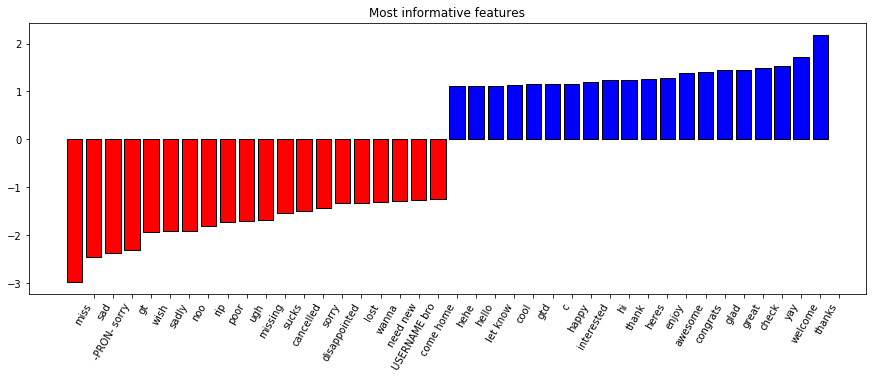

In [15]:
# trying again with new stopwords
new_stop_words = text.ENGLISH_STOP_WORDS.union(['b', 'd'])

tf_3 = TfidfVectorizer(ngram_range=(1,3), max_df = 0.8, min_df = 3, preprocessor=tweet_preprocessor, tokenizer=tweet_tokenizer, stop_words=new_stop_words)

X_train_tf3 = tf_3.fit_transform(X_train)
X_test_tf3  = tf_3.transform(X_test)

svm = SGDClassifier(loss='modified_huber', penalty='l2', random_state=11)

svm.fit(X_train_tf3, y_train)
y_pred_svm = svm.predict(X_test_tf3)

plot_coefficients(svm, tf_3.get_feature_names())

In [30]:
conf_matrix(y_test, y_pred_svm)

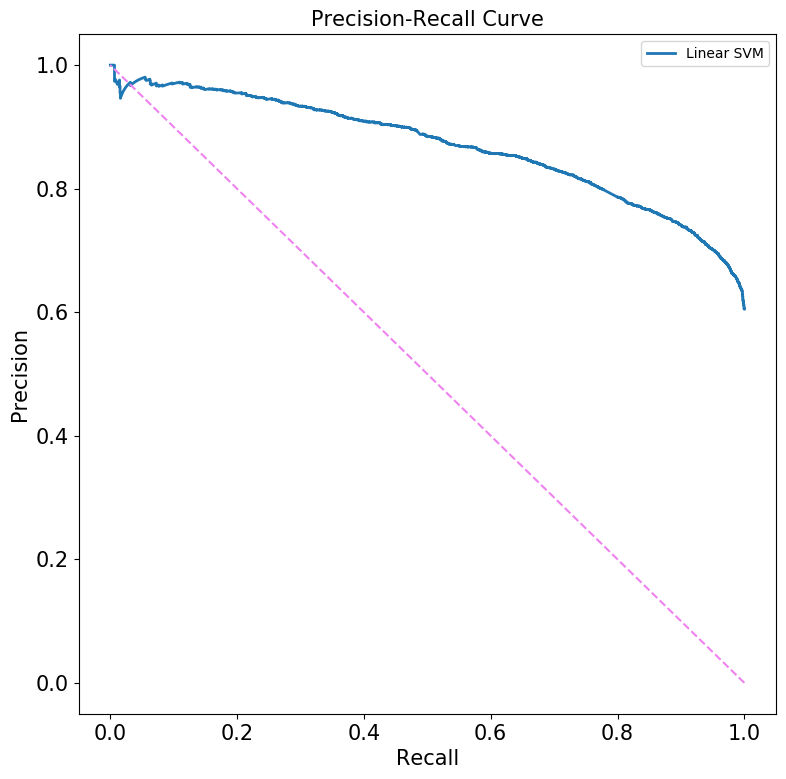

In [31]:
svm_curve = prec_rec_curve_generator(X_test_tf3, y_test, 'Linear SVM', svm)

In [28]:
# Create a widget to show confusion matrix and the precision and recall scores given a sliding threshold value as an input
@interact(thresh=(0, 1, .01))
def logit_confusion(thresh):
    y_predict = (svm.predict_proba(X_test_tf3)[:, 1] > thresh)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fbeta = (precision*recall)/((1**2*precision+recall)/(1**2+1))
    logit_confusion = confusion_matrix(y_test, y_predict)
    
    plt.figure(dpi=150)
    ax = sns.heatmap(logit_confusion, cmap=plt.cm.Purples, annot=True, square=True, fmt='g',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('SVM Confusion Matrix');
    
    return 'Threshold: ' + str(thresh), "Precision: {:6.4f},   Recall: {:6.4f},    F-beta: {:6.4f}".format(precision, recall, fbeta)


interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.01), Output()), _dom_classe…

#### Optimal Threshold: 0.44 (Precision: 0.738, Recall: 0.907, F-beta: 0.813)

In [16]:
optimal_threshold = 0.44

## Step 5: Apply LinearSVM model to our climate tweets

In [17]:
X_final_train = X
y_final_train = y

X_final_train_tf3 = tf_3.fit_transform(X_final_train)

model_final = SGDClassifier(loss='modified_huber', penalty='l2', random_state=11)
model_final.fit(X_final_train_tf3, y_final_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=11, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
twitter_username_re = re.compile(r"(^|[^\w@/\!?=&])@(\w{1,15})\b")
url_re = re.compile(r"\bhttps://t.co/\w+")
num_re = re.compile(r"\w*\d\w*")
hashtag_re = re.compile(r"\B(\#[a-zA-Z]+\b)(?!;)")

def is_english(tweet):
    # users, hashtags, numbers, urls mess with the detector, so remove them
    tweet = twitter_username_re.sub("", tweet)
    tweet = url_re.sub("", tweet)
    tweet = hashtag_re.sub(" ", tweet)
    tweet = tweet.replace("#", "").replace("…", "")
    tweet = tweet.replace("&amp;", "").replace("@", "")
    tweet = tweet.replace("<NEWLINE> ", "")
    
    try:
        lang = cld3.get_language(tweet)
        # if we're not sure, just say it's english
        if not lang.is_reliable:
            return True
        return lang.language == 'en'
    
    
    # again, if we're not sure, just say it's english
    except:
        return True

In [23]:
def classify_tweets(location, before_after):
    # grab tweets from file
    f = open("../data-collection/climate-tweets/" + location.lower() + "-climate-tweets-" + before_after + ".txt", 'r')
    file_content = f.readlines()
    f.close()
    
    # populate test set with tweet text
    X_final_test = []
    for line in file_content:
        # ignore the type of climate change tweet
        reduced_line = '\t'.join(line.split('\t')[:-1])
        # get only the tweet text without emojis
        tweet_text = give_emoji_free_text(reduced_line.split('\t', 2)[2])
        if tweet_text[:2] == "RT" or not is_english(tweet_text):
            continue
        X_final_test.append(tweet_text.replace("<NEWLINE>", ""))
        
    # use model to predict classification of tweets
    X_final_test_tf3 = tf_3.transform(X_final_test)
    y_final_predict = model_final.predict_proba(X_final_test_tf3)
    
    # classify tweets using predicted probabilities and optimal threshold
    num_positive = 0
    num_negative = 0
    sentiment_preds = []
    for i in y_final_predict:
        if i[1] < optimal_threshold:
            num_negative += 1
            sentiment_preds.append(0)
        else:
            num_positive += 1
            sentiment_preds.append(1)
            
    # report results
    pct_positive = round(num_positive / len(X_final_test), 4) * 100
    pct_negative   = round(num_negative / len(X_final_test), 4) * 100
    
    print(location.upper(), "CLIMATE TWEETS FROM", before_after.upper(), "COVID-19")
    print("---------------------------------------------------")
    print(num_positive, "tweets classified as positive")
    print(num_negative, "tweets classified as negative")
    print(pct_positive, "% positive, ", pct_negative, "% negative\n")
    
    # show examples
    pos_examples = []
    neg_examples = []
    for i in np.arange(len(X_final_test)):
        sent = sentiment_preds[i]
        if sent == 1 and len(pos_examples) < 3:
            pos_examples += [X_final_test[i]]
        elif sent == 0 and len(neg_examples) < 3:
            neg_examples += [X_final_test[i]]
        
        if len(pos_examples) >= 3 and len(neg_examples) >= 3:
            break
    
    print("EXAMPLES:")
    print("Positive:")
    for x in pos_examples:
        print('-', x)
    print("\nNegative:")
    for x in neg_examples:
        print('-', x)
    print('\n')
    
    return pct_negative

Sydney
SYDNEY CLIMATE TWEETS FROM BEFORE COVID-19
---------------------------------------------------
959 tweets classified as positive
27 tweets classified as negative
97.26 % positive,  2.74 % negative

EXAMPLES:
Positive:
- Good to see Obama shirtfront Abbott on climate change.
- You can act now by not buying palm oil products from country's destroying our environment and endangered species. C… https://t.co/wtpuLJVx7K
- @RoasterMcD @percyvale21 @GuardianAus A policy free zone, on climate and energy

Negative:
- @RDNS_TAI @Megan_Johnston So... how to pitch the environment as a hip lifestyle choice? Sadly may be more effective.
- I hate working in a bakery in summer I am wet in places you just don’t want to no about #Heatwave #Sydney
- Please don't toss out your trash into the streets. Put it in the bin where it belongs!! #greenie #environment


SYDNEY CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
384 tweets classified as positive
16 tweets cla

LA CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
1318 tweets classified as positive
48 tweets classified as negative
96.49 % positive,  3.51 % negative

EXAMPLES:
Positive:
- If our body is all electric and we add more electrical waves &amp; radiation to the environment, you CANT CANT CANT CAN… https://t.co/A5xDhyQXp0
- buffyfan145: Just got to watch “I Still Believe” and loved it!!! :D I’ve been a fan of Jeremy Camp’s for about 18 y… https://t.co/fGGNd3vYqt
- @latimes On the bright side the energy off this bad take just solved climate change

Negative:
- Look like it’s finna be a drought
- @SSLGND what. The. FUCK https://t.co/hrHlS340jN
- A carona virus haiku for you @kaitlynmcquin   Quarantined and sad  Season 2 of Breaking Bad  See you all in May https://t.co/gndLtJegBT




Text(0.5, 1.0, 'Percent of climate tweets classified as negative')

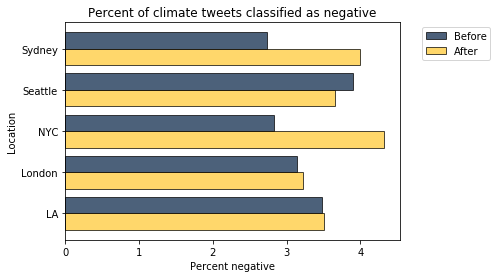

In [24]:
loc_list = ["Sydney", "Seattle", "NYC", "London", "LA"]
before = []
after = []

for loc in loc_list:
    print(loc)
    before.append(classify_tweets(loc, "before"))
    after.append(classify_tweets(loc, "after"))
    
table = Table().with_columns("Location", loc_list,
                             "Before", before,
                             "After", after)

table.barh("Location")
plt.xlabel("Percent negative")
plt.title("Percent of climate tweets classified as negative")

In [26]:
def classify_all_tweets(ba):
    # grab tweets from file
    f = open("../data-collection/climate-tweets/" + ba + "-covid-climate-tweets-all.txt", 'r')
    file_content = f.readlines()
    f.close()
    
    # populate test set with tweet text
    X_final_test = []
    for line in file_content:
        # ignore the type of climate change tweet
        reduced_line = '\t'.join(line.split('\t')[:-1])
        # get only the tweet text without emojis
        tweet_text = give_emoji_free_text(reduced_line.split('\t', 2)[2])
        if tweet_text[:2] == "RT" or not is_english(tweet_text):
            continue
        X_final_test.append(tweet_text.replace("<NEWLINE>", ""))
        
    # use model to predict classification of tweets
    X_final_test_tf3 = tf_3.transform(X_final_test)
    y_final_predict = model_final.predict_proba(X_final_test_tf3)
    
    # classify tweets using predicted probabilities and optimal threshold
    num_positive = 0
    num_negative = 0
    sentiment_preds = []
    for i in y_final_predict:
        if i[1] < optimal_threshold:
            num_negative += 1
            sentiment_preds.append(0)
        else:
            num_positive += 1
            sentiment_preds.append(1)
            
    # report results
    pct_positive = round(num_positive / len(X_final_test), 4) * 100
    pct_negative   = round(num_negative / len(X_final_test), 4) * 100
    
    print("ALL CLIMATE TWEETS FROM", ba.upper(), "COVID-19")
    print("---------------------------------------------------")
    print(num_positive, "tweets classified as positive")
    print(num_negative, "tweets classified as negative")
    print(pct_positive, "% positive, ", pct_negative, "% negative\n")
    
    # show examples
    pos_examples = []
    neg_examples = []
    for i in np.arange(len(X_final_test)):
        sent = sentiment_preds[i]
        if sent == 1 and len(pos_examples) < 3:
            pos_examples += [X_final_test[i]]
        elif sent == 0 and len(neg_examples) < 3:
            neg_examples += [X_final_test[i]]
        
        if len(pos_examples) >= 3 and len(neg_examples) >= 3:
            break
    
    print("EXAMPLES:")
    print("Positive:")
    for x in pos_examples:
        print('-', x)
    print("\nNegative:")
    for x in neg_examples:
        print('-', x)
    print('\n')

In [27]:
classify_all_tweets("before")
classify_all_tweets("after")

ALL CLIMATE TWEETS FROM BEFORE COVID-19
---------------------------------------------------
7916 tweets classified as positive
254 tweets classified as negative
96.89 % positive,  3.11 % negative

EXAMPLES:
Positive:
- Good to see Obama shirtfront Abbott on climate change.
- You can act now by not buying palm oil products from country's destroying our environment and endangered species. C… https://t.co/wtpuLJVx7K
- @RoasterMcD @percyvale21 @GuardianAus A policy free zone, on climate and energy

Negative:
- @RDNS_TAI @Megan_Johnston So... how to pitch the environment as a hip lifestyle choice? Sadly may be more effective.
- I hate working in a bakery in summer I am wet in places you just don’t want to no about #Heatwave #Sydney
- Please don't toss out your trash into the streets. Put it in the bin where it belongs!! #greenie #environment


ALL CLIMATE TWEETS FROM AFTER COVID-19
---------------------------------------------------
4614 tweets classified as positive
176 tweets classified a